In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 48kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


In [3]:
import tensorflow as tf

tf.reset_default_graph()

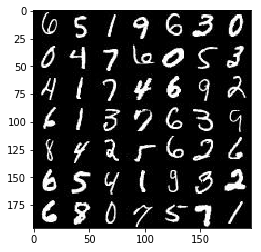

In [4]:
show_n_images = 49

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap = 'gray')

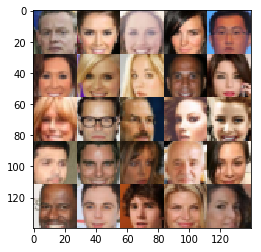

In [5]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [6]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, (None))
    return inputs_real, inputs_z, learning_rate

tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

In [25]:
def discriminator(images, reuse=False, training = True, alpha = 0.2, dropout = 0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation = tf.nn.elu)
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(x1, alpha * x1)
        x1 = tf.nn.dropout(x1, keep_prob = dropout)

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.elu)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob = dropout)

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.elu)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob = dropout)
        x3 = tf.reshape(x3, (-1, 4*4*256))
        
        logits = tf.layers.dense(x3, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


In [26]:
def generator(z, out_channel_dim, is_train=True, reuse = False , alpha = 0.2, dropout = 0.8):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # Start with fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Reshape to start convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob = dropout)
        # Image size = 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob = dropout)
        # Image size = 8x8x128
    
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob = dropout)
        # Image size = 16x16x64
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob = dropout)
        # Image size = 32x32x32
        
        # Create the final layer with depth=output_channel_dim
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        # Image size = 28x28x3 
        
        # Use tanh for output
        output = tf.tanh(logits)

    return output
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In [27]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)
                                                * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_fake + d_loss_real
    
    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


In [29]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [30]:
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                start_time = time.time()
                step = step+1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print('batch_z shape=',batch_z.shape)
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate})
                
                if step % 100 == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, step),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g),
                      "... Time spent={:.4f}".format(time.time() - start_time))    

                if step % 200 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

Epoch 1/3 Step 100... Discriminator Loss: 0.4791... Generator Loss: 4.0329 ... Time spent=0.2094
Epoch 1/3 Step 200... Discriminator Loss: 0.6649... Generator Loss: 4.1620 ... Time spent=0.1465


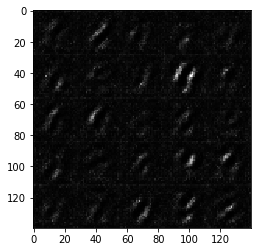

Epoch 1/3 Step 300... Discriminator Loss: 0.7637... Generator Loss: 2.3094 ... Time spent=0.1462
Epoch 1/3 Step 400... Discriminator Loss: 0.6569... Generator Loss: 2.2413 ... Time spent=0.1470


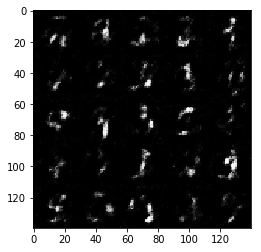

Epoch 1/3 Step 500... Discriminator Loss: 0.7017... Generator Loss: 1.9449 ... Time spent=0.1463
Epoch 1/3 Step 600... Discriminator Loss: 0.7632... Generator Loss: 2.5691 ... Time spent=0.1470


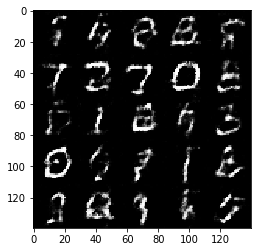

Epoch 1/3 Step 700... Discriminator Loss: 0.8143... Generator Loss: 2.0337 ... Time spent=0.1462
Epoch 1/3 Step 800... Discriminator Loss: 1.0212... Generator Loss: 1.1796 ... Time spent=0.1466


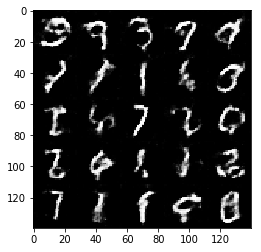

Epoch 1/3 Step 900... Discriminator Loss: 0.7424... Generator Loss: 1.9700 ... Time spent=0.1468
Epoch 2/3 Step 1000... Discriminator Loss: 0.7124... Generator Loss: 2.2354 ... Time spent=0.1469


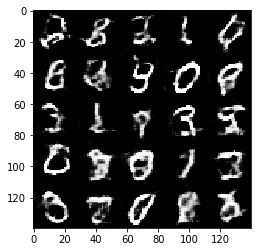

Epoch 2/3 Step 1100... Discriminator Loss: 0.9222... Generator Loss: 2.0287 ... Time spent=0.1464
Epoch 2/3 Step 1200... Discriminator Loss: 0.7673... Generator Loss: 1.6379 ... Time spent=0.1470


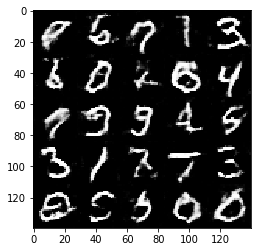

Epoch 2/3 Step 1300... Discriminator Loss: 0.8921... Generator Loss: 2.4698 ... Time spent=0.1474
Epoch 2/3 Step 1400... Discriminator Loss: 0.8792... Generator Loss: 1.4657 ... Time spent=0.1467


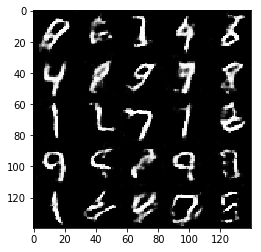

Epoch 2/3 Step 1500... Discriminator Loss: 0.6661... Generator Loss: 2.0052 ... Time spent=0.1470
Epoch 2/3 Step 1600... Discriminator Loss: 0.5795... Generator Loss: 1.8915 ... Time spent=0.1473


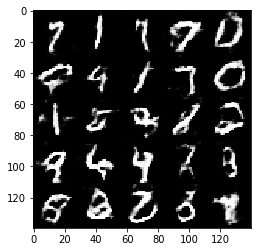

Epoch 2/3 Step 1700... Discriminator Loss: 0.5927... Generator Loss: 2.9228 ... Time spent=0.1471
Epoch 2/3 Step 1800... Discriminator Loss: 0.6414... Generator Loss: 3.0922 ... Time spent=0.1479


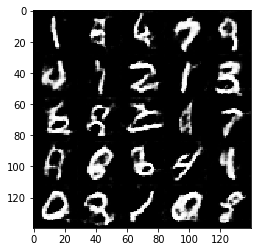

Epoch 3/3 Step 1900... Discriminator Loss: 0.5083... Generator Loss: 2.5439 ... Time spent=0.1464
Epoch 3/3 Step 2000... Discriminator Loss: 0.4777... Generator Loss: 3.0071 ... Time spent=0.1476


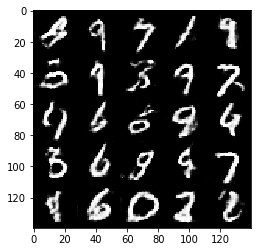

Epoch 3/3 Step 2100... Discriminator Loss: 0.5636... Generator Loss: 2.2926 ... Time spent=0.1474
Epoch 3/3 Step 2200... Discriminator Loss: 0.5311... Generator Loss: 2.4435 ... Time spent=0.1484


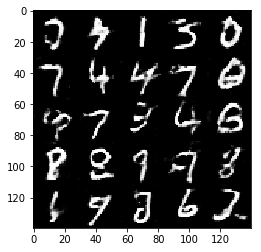

Epoch 3/3 Step 2300... Discriminator Loss: 0.4412... Generator Loss: 3.6975 ... Time spent=0.1501
Epoch 3/3 Step 2400... Discriminator Loss: 0.4332... Generator Loss: 3.6299 ... Time spent=0.1496


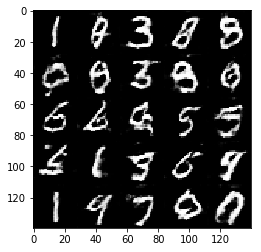

Epoch 3/3 Step 2500... Discriminator Loss: 0.5347... Generator Loss: 2.3958 ... Time spent=0.1492
Epoch 3/3 Step 2600... Discriminator Loss: 0.5578... Generator Loss: 1.7529 ... Time spent=0.1502


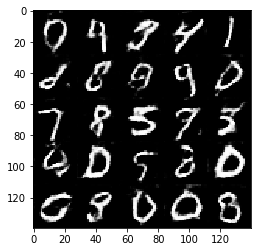

Epoch 3/3 Step 2700... Discriminator Loss: 0.4829... Generator Loss: 2.6754 ... Time spent=0.1477


In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


tf.reset_default_graph()

epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/10 Step 100... Discriminator Loss: 0.3631... Generator Loss: 5.3996 ... Time spent=0.1930
Epoch 1/10 Step 200... Discriminator Loss: 0.3624... Generator Loss: 7.2729 ... Time spent=0.1391


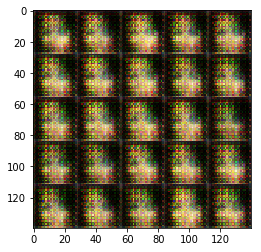

Epoch 1/10 Step 300... Discriminator Loss: 0.5292... Generator Loss: 4.7357 ... Time spent=0.1381
Epoch 1/10 Step 400... Discriminator Loss: 0.4490... Generator Loss: 6.0939 ... Time spent=0.1430


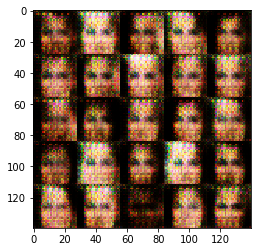

Epoch 1/10 Step 500... Discriminator Loss: 0.4581... Generator Loss: 3.0355 ... Time spent=0.1396
Epoch 1/10 Step 600... Discriminator Loss: 0.6894... Generator Loss: 5.3425 ... Time spent=0.1417


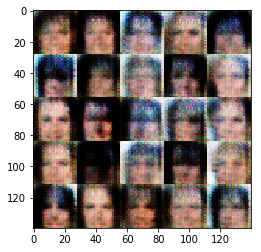

Epoch 1/10 Step 700... Discriminator Loss: 0.5252... Generator Loss: 2.4173 ... Time spent=0.1362
Epoch 1/10 Step 800... Discriminator Loss: 0.9192... Generator Loss: 1.2702 ... Time spent=0.1430


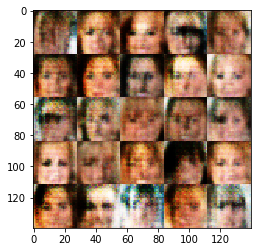

Epoch 1/10 Step 900... Discriminator Loss: 0.7681... Generator Loss: 1.5361 ... Time spent=0.1436
Epoch 1/10 Step 1000... Discriminator Loss: 1.0086... Generator Loss: 0.9472 ... Time spent=0.1439


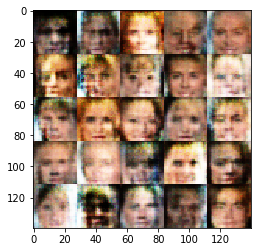

Epoch 1/10 Step 1100... Discriminator Loss: 0.9442... Generator Loss: 1.0472 ... Time spent=0.1421
Epoch 1/10 Step 1200... Discriminator Loss: 0.7231... Generator Loss: 1.5417 ... Time spent=0.1413


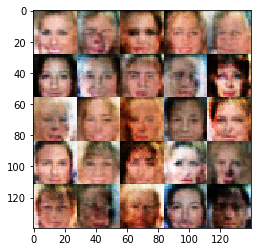

Epoch 1/10 Step 1300... Discriminator Loss: 0.8296... Generator Loss: 1.2142 ... Time spent=0.1428
Epoch 1/10 Step 1400... Discriminator Loss: 0.6415... Generator Loss: 1.9588 ... Time spent=0.1430


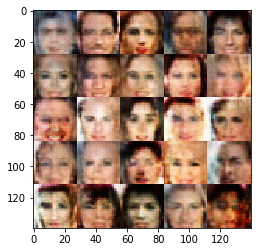

Epoch 1/10 Step 1500... Discriminator Loss: 0.7132... Generator Loss: 1.4590 ... Time spent=0.1429
Epoch 1/10 Step 1600... Discriminator Loss: 0.7588... Generator Loss: 1.4513 ... Time spent=0.1429


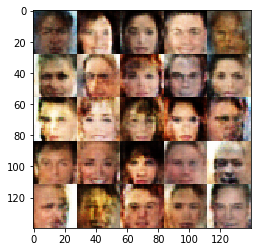

Epoch 1/10 Step 1700... Discriminator Loss: 0.7192... Generator Loss: 1.5601 ... Time spent=0.1416
Epoch 1/10 Step 1800... Discriminator Loss: 0.6957... Generator Loss: 2.2790 ... Time spent=0.1444


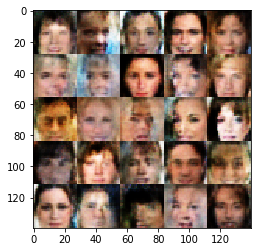

Epoch 1/10 Step 1900... Discriminator Loss: 0.8578... Generator Loss: 1.2217 ... Time spent=0.1340
Epoch 1/10 Step 2000... Discriminator Loss: 0.6925... Generator Loss: 1.7269 ... Time spent=0.1423


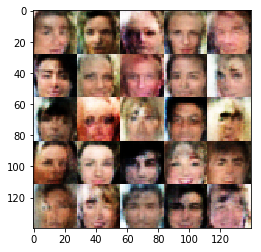

Epoch 1/10 Step 2100... Discriminator Loss: 0.7342... Generator Loss: 1.9241 ... Time spent=0.1351
Epoch 1/10 Step 2200... Discriminator Loss: 0.8379... Generator Loss: 1.1676 ... Time spent=0.1414


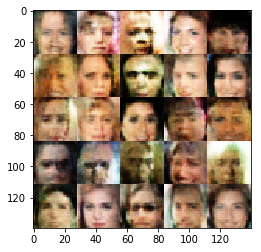

Epoch 1/10 Step 2300... Discriminator Loss: 1.2917... Generator Loss: 0.6617 ... Time spent=0.1335
Epoch 1/10 Step 2400... Discriminator Loss: 0.9655... Generator Loss: 1.0960 ... Time spent=0.1435


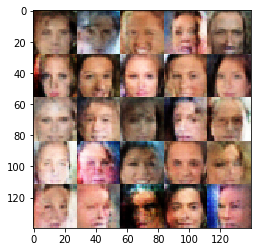

Epoch 1/10 Step 2500... Discriminator Loss: 0.7552... Generator Loss: 1.4138 ... Time spent=0.1336
Epoch 1/10 Step 2600... Discriminator Loss: 0.9684... Generator Loss: 0.9991 ... Time spent=0.1436


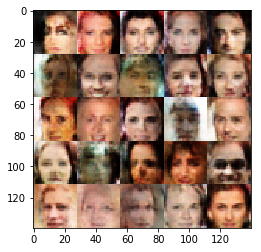

Epoch 1/10 Step 2700... Discriminator Loss: 0.8054... Generator Loss: 1.1832 ... Time spent=0.1424
Epoch 1/10 Step 2800... Discriminator Loss: 0.7218... Generator Loss: 1.4562 ... Time spent=0.1409


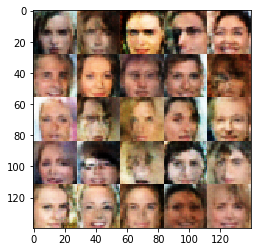

Epoch 1/10 Step 2900... Discriminator Loss: 0.8397... Generator Loss: 1.2794 ... Time spent=0.1426
Epoch 1/10 Step 3000... Discriminator Loss: 0.8023... Generator Loss: 1.2348 ... Time spent=0.1417


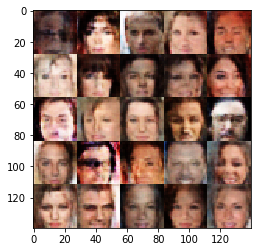

Epoch 1/10 Step 3100... Discriminator Loss: 0.8371... Generator Loss: 1.2368 ... Time spent=0.1420
Epoch 2/10 Step 3200... Discriminator Loss: 1.1178... Generator Loss: 0.9477 ... Time spent=0.1421


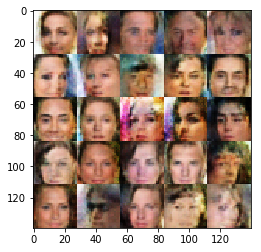

Epoch 2/10 Step 3300... Discriminator Loss: 1.5715... Generator Loss: 0.5045 ... Time spent=0.1323
Epoch 2/10 Step 3400... Discriminator Loss: 0.6682... Generator Loss: 1.5748 ... Time spent=0.1306


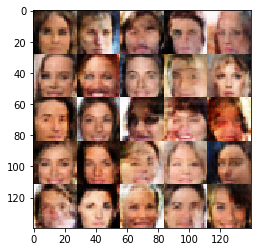

Epoch 2/10 Step 3500... Discriminator Loss: 0.8502... Generator Loss: 1.1975 ... Time spent=0.1391
Epoch 2/10 Step 3600... Discriminator Loss: 1.6525... Generator Loss: 0.4744 ... Time spent=0.1382


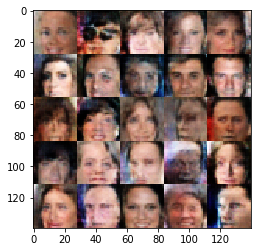

Epoch 2/10 Step 3700... Discriminator Loss: 0.7747... Generator Loss: 1.3721 ... Time spent=0.1322
Epoch 2/10 Step 3800... Discriminator Loss: 0.9446... Generator Loss: 1.0185 ... Time spent=0.1330


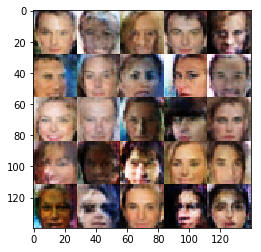

Epoch 2/10 Step 3900... Discriminator Loss: 0.7692... Generator Loss: 1.4496 ... Time spent=0.1313
Epoch 2/10 Step 4000... Discriminator Loss: 0.7714... Generator Loss: 1.5807 ... Time spent=0.1312


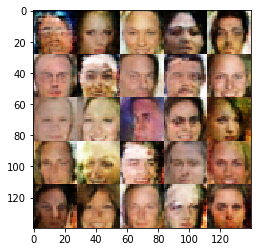

Epoch 2/10 Step 4100... Discriminator Loss: 0.7568... Generator Loss: 1.4127 ... Time spent=0.1381
Epoch 2/10 Step 4200... Discriminator Loss: 0.7464... Generator Loss: 1.4654 ... Time spent=0.1318


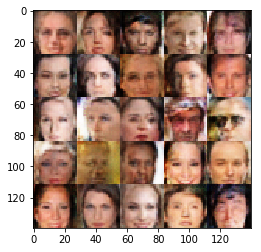

Epoch 2/10 Step 4300... Discriminator Loss: 0.6984... Generator Loss: 1.5095 ... Time spent=0.1419
Epoch 2/10 Step 4400... Discriminator Loss: 0.8268... Generator Loss: 1.2739 ... Time spent=0.1328


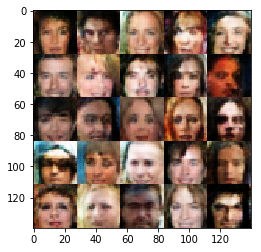

Epoch 2/10 Step 4500... Discriminator Loss: 1.1551... Generator Loss: 0.7725 ... Time spent=0.1329
Epoch 2/10 Step 4600... Discriminator Loss: 0.7125... Generator Loss: 1.5509 ... Time spent=0.1307


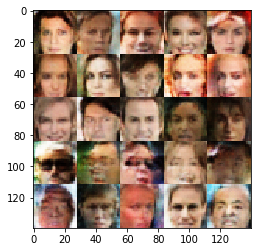

Epoch 2/10 Step 4700... Discriminator Loss: 1.2781... Generator Loss: 0.6381 ... Time spent=0.1379
Epoch 2/10 Step 4800... Discriminator Loss: 1.2501... Generator Loss: 0.7373 ... Time spent=0.1395


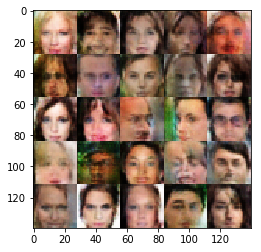

Epoch 2/10 Step 4900... Discriminator Loss: 1.6214... Generator Loss: 0.4913 ... Time spent=0.1311
Epoch 2/10 Step 5000... Discriminator Loss: 0.9129... Generator Loss: 1.1176 ... Time spent=0.1390


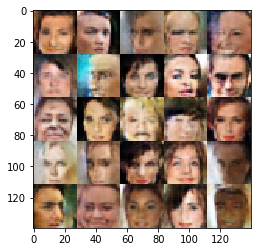

Epoch 2/10 Step 5100... Discriminator Loss: 1.3259... Generator Loss: 0.6609 ... Time spent=0.1302
Epoch 2/10 Step 5200... Discriminator Loss: 0.8556... Generator Loss: 1.1419 ... Time spent=0.1310


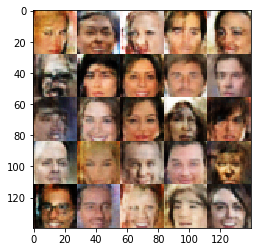

Epoch 2/10 Step 5300... Discriminator Loss: 0.7995... Generator Loss: 1.4379 ... Time spent=0.1388
Epoch 2/10 Step 5400... Discriminator Loss: 0.7967... Generator Loss: 1.2591 ... Time spent=0.1315


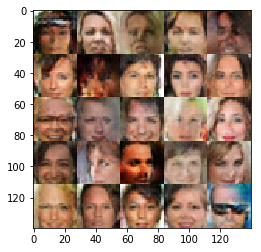

Epoch 2/10 Step 5500... Discriminator Loss: 1.0165... Generator Loss: 1.0238 ... Time spent=0.1324
Epoch 2/10 Step 5600... Discriminator Loss: 0.9444... Generator Loss: 1.0775 ... Time spent=0.1436


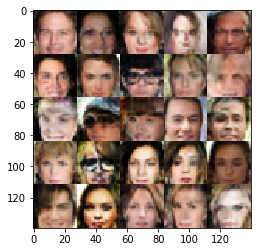

Epoch 2/10 Step 5700... Discriminator Loss: 1.0409... Generator Loss: 0.8805 ... Time spent=0.1422
Epoch 2/10 Step 5800... Discriminator Loss: 2.2016... Generator Loss: 0.3379 ... Time spent=0.1417


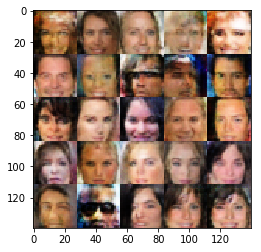

Epoch 2/10 Step 5900... Discriminator Loss: 1.0979... Generator Loss: 0.8548 ... Time spent=0.1390
Epoch 2/10 Step 6000... Discriminator Loss: 0.7975... Generator Loss: 1.2946 ... Time spent=0.1331


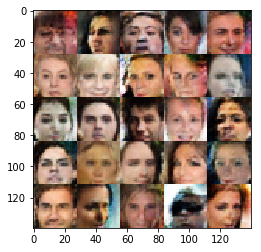

Epoch 2/10 Step 6100... Discriminator Loss: 0.7748... Generator Loss: 1.4114 ... Time spent=0.1317
Epoch 2/10 Step 6200... Discriminator Loss: 0.8512... Generator Loss: 1.1450 ... Time spent=0.1305


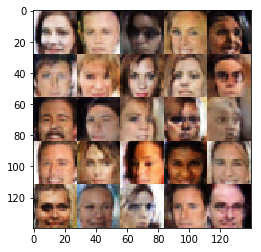

Epoch 2/10 Step 6300... Discriminator Loss: 1.1355... Generator Loss: 0.8462 ... Time spent=0.1381
Epoch 3/10 Step 6400... Discriminator Loss: 0.7836... Generator Loss: 1.6510 ... Time spent=0.1317


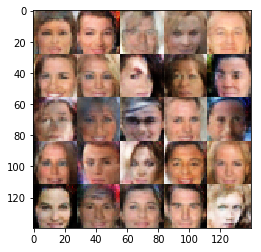

Epoch 3/10 Step 6500... Discriminator Loss: 0.9250... Generator Loss: 1.0793 ... Time spent=0.1308
Epoch 3/10 Step 6600... Discriminator Loss: 1.3431... Generator Loss: 0.6333 ... Time spent=0.1313


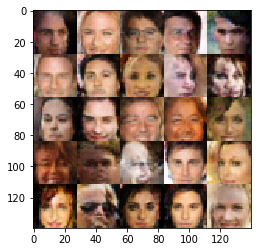

Epoch 3/10 Step 6700... Discriminator Loss: 0.5619... Generator Loss: 2.0493 ... Time spent=0.1301
Epoch 3/10 Step 6800... Discriminator Loss: 0.7159... Generator Loss: 1.4522 ... Time spent=0.1381


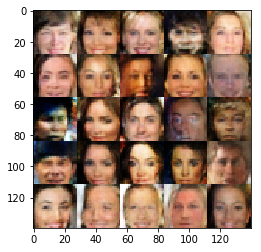

Epoch 3/10 Step 6900... Discriminator Loss: 1.7814... Generator Loss: 0.4639 ... Time spent=0.1330
Epoch 3/10 Step 7000... Discriminator Loss: 1.1439... Generator Loss: 0.7880 ... Time spent=0.1302


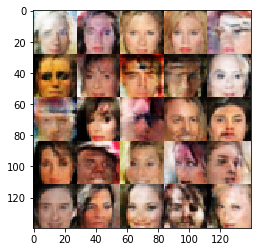

Epoch 3/10 Step 7100... Discriminator Loss: 0.9676... Generator Loss: 1.0228 ... Time spent=0.1369
Epoch 3/10 Step 7200... Discriminator Loss: 0.9282... Generator Loss: 1.1480 ... Time spent=0.1313


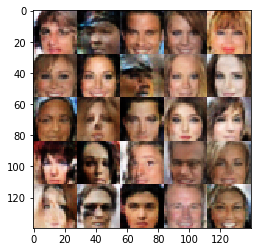

Epoch 3/10 Step 7300... Discriminator Loss: 0.8880... Generator Loss: 1.0921 ... Time spent=0.1305
Epoch 3/10 Step 7400... Discriminator Loss: 0.8478... Generator Loss: 1.2520 ... Time spent=0.1301


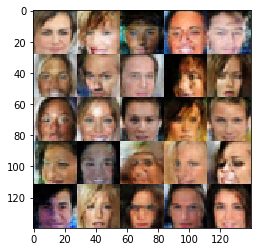

Epoch 3/10 Step 7500... Discriminator Loss: 0.8546... Generator Loss: 2.0564 ... Time spent=0.1379
Epoch 3/10 Step 7600... Discriminator Loss: 0.6861... Generator Loss: 1.5517 ... Time spent=0.1383


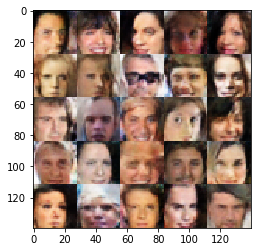

Epoch 3/10 Step 7700... Discriminator Loss: 1.4321... Generator Loss: 0.5896 ... Time spent=0.1326
Epoch 3/10 Step 7800... Discriminator Loss: 0.9846... Generator Loss: 1.0356 ... Time spent=0.1392


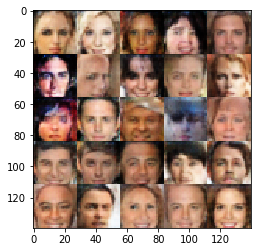

Epoch 3/10 Step 7900... Discriminator Loss: 0.9489... Generator Loss: 3.1503 ... Time spent=0.1382
Epoch 3/10 Step 8000... Discriminator Loss: 0.7726... Generator Loss: 1.2622 ... Time spent=0.1392


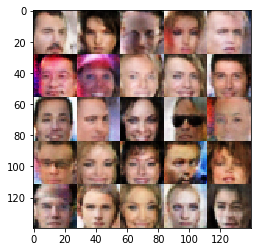

Epoch 3/10 Step 8100... Discriminator Loss: 0.9645... Generator Loss: 1.0644 ... Time spent=0.1377
Epoch 3/10 Step 8200... Discriminator Loss: 1.0998... Generator Loss: 0.7858 ... Time spent=0.1380


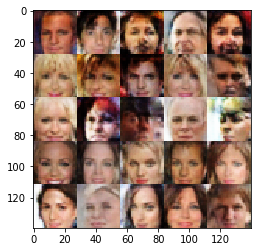

Epoch 3/10 Step 8300... Discriminator Loss: 0.5906... Generator Loss: 2.3084 ... Time spent=0.1379
Epoch 3/10 Step 8400... Discriminator Loss: 0.8121... Generator Loss: 1.3060 ... Time spent=0.1325


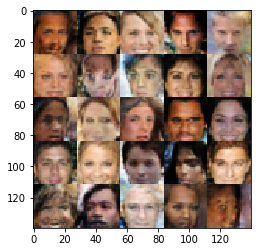

Epoch 3/10 Step 8500... Discriminator Loss: 0.9600... Generator Loss: 1.0023 ... Time spent=0.1308
Epoch 3/10 Step 8600... Discriminator Loss: 0.6482... Generator Loss: 1.8800 ... Time spent=0.1308


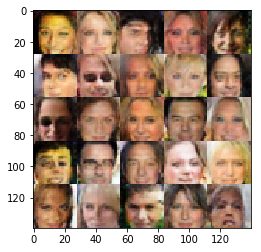

Epoch 3/10 Step 8700... Discriminator Loss: 0.7318... Generator Loss: 1.5345 ... Time spent=0.1407
Epoch 3/10 Step 8800... Discriminator Loss: 0.7650... Generator Loss: 1.3213 ... Time spent=0.1412


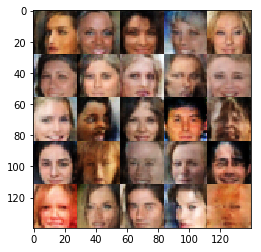

Epoch 3/10 Step 8900... Discriminator Loss: 0.6989... Generator Loss: 2.1285 ... Time spent=0.1423
Epoch 3/10 Step 9000... Discriminator Loss: 1.3687... Generator Loss: 0.6621 ... Time spent=0.1328


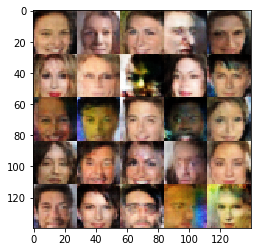

Epoch 3/10 Step 9100... Discriminator Loss: 1.0017... Generator Loss: 1.1332 ... Time spent=0.1299
Epoch 3/10 Step 9200... Discriminator Loss: 0.7487... Generator Loss: 1.4428 ... Time spent=0.1302


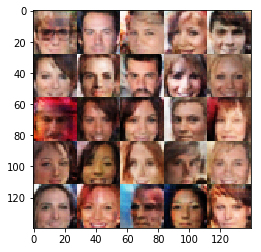

Epoch 3/10 Step 9300... Discriminator Loss: 1.7353... Generator Loss: 0.6018 ... Time spent=0.1309
Epoch 3/10 Step 9400... Discriminator Loss: 1.2597... Generator Loss: 0.6915 ... Time spent=0.1379


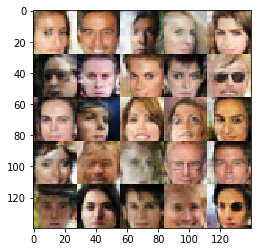

Epoch 4/10 Step 9500... Discriminator Loss: 0.7455... Generator Loss: 1.4269 ... Time spent=0.1386
Epoch 4/10 Step 9600... Discriminator Loss: 1.2651... Generator Loss: 0.6827 ... Time spent=0.1379


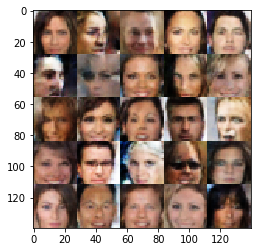

Epoch 4/10 Step 9700... Discriminator Loss: 0.7926... Generator Loss: 1.1653 ... Time spent=0.1442
Epoch 4/10 Step 9800... Discriminator Loss: 0.7401... Generator Loss: 2.5529 ... Time spent=0.1349


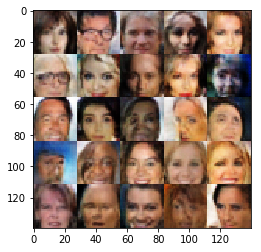

Epoch 4/10 Step 9900... Discriminator Loss: 0.7561... Generator Loss: 1.4602 ... Time spent=0.1308
Epoch 4/10 Step 10000... Discriminator Loss: 0.9745... Generator Loss: 1.0322 ... Time spent=0.1311


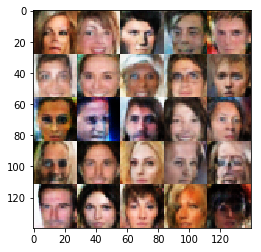

Epoch 4/10 Step 10100... Discriminator Loss: 1.3297... Generator Loss: 0.6098 ... Time spent=0.1422
Epoch 4/10 Step 10200... Discriminator Loss: 1.5522... Generator Loss: 0.4889 ... Time spent=0.1403


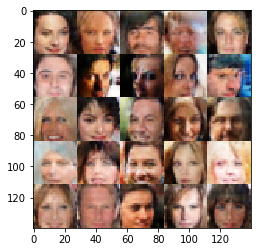

Epoch 4/10 Step 10300... Discriminator Loss: 1.3081... Generator Loss: 0.7294 ... Time spent=0.1300
Epoch 4/10 Step 10400... Discriminator Loss: 1.6240... Generator Loss: 0.5707 ... Time spent=0.1411


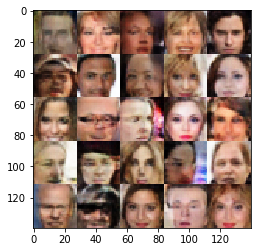

Epoch 4/10 Step 10500... Discriminator Loss: 0.8864... Generator Loss: 1.1930 ... Time spent=0.1324
Epoch 4/10 Step 10600... Discriminator Loss: 0.7505... Generator Loss: 1.3913 ... Time spent=0.1316


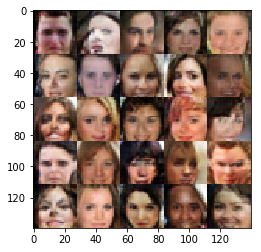

Epoch 4/10 Step 10700... Discriminator Loss: 0.8566... Generator Loss: 2.2958 ... Time spent=0.1305
Epoch 4/10 Step 10800... Discriminator Loss: 1.4326... Generator Loss: 0.5696 ... Time spent=0.1296


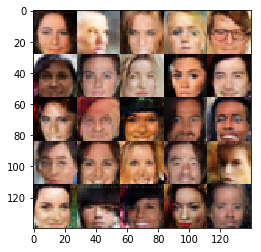

Epoch 4/10 Step 10900... Discriminator Loss: 1.3321... Generator Loss: 0.6763 ... Time spent=0.1395
Epoch 4/10 Step 11000... Discriminator Loss: 0.8906... Generator Loss: 1.0473 ... Time spent=0.1296


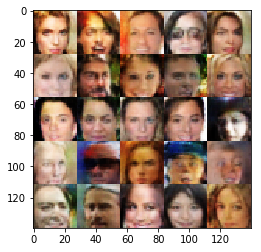

Epoch 4/10 Step 11100... Discriminator Loss: 0.9938... Generator Loss: 0.9521 ... Time spent=0.1380
Epoch 4/10 Step 11200... Discriminator Loss: 0.8142... Generator Loss: 1.3268 ... Time spent=0.1310


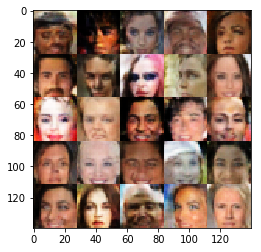

Epoch 4/10 Step 11300... Discriminator Loss: 0.9944... Generator Loss: 1.1297 ... Time spent=0.1321
Epoch 4/10 Step 11400... Discriminator Loss: 1.0311... Generator Loss: 0.9074 ... Time spent=0.1317


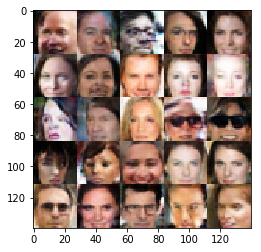

Epoch 4/10 Step 11500... Discriminator Loss: 0.9322... Generator Loss: 1.0159 ... Time spent=0.1397
Epoch 4/10 Step 11600... Discriminator Loss: 1.0625... Generator Loss: 0.9176 ... Time spent=0.1382


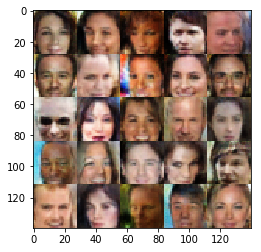

Epoch 4/10 Step 11700... Discriminator Loss: 1.3522... Generator Loss: 0.7750 ... Time spent=0.1330
Epoch 4/10 Step 11800... Discriminator Loss: 1.0562... Generator Loss: 0.9550 ... Time spent=0.1397


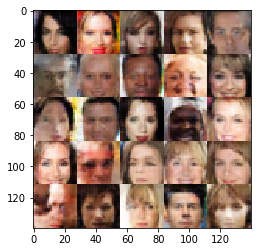

Epoch 4/10 Step 11900... Discriminator Loss: 0.8053... Generator Loss: 1.2980 ... Time spent=0.1313
Epoch 4/10 Step 12000... Discriminator Loss: 1.2498... Generator Loss: 0.6957 ... Time spent=0.1325


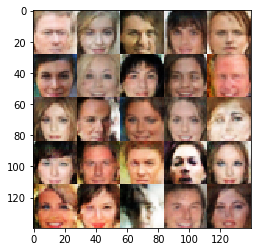

Epoch 4/10 Step 12100... Discriminator Loss: 0.9898... Generator Loss: 1.0011 ... Time spent=0.1416
Epoch 4/10 Step 12200... Discriminator Loss: 1.5812... Generator Loss: 0.4481 ... Time spent=0.1298


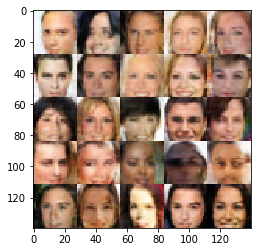

Epoch 4/10 Step 12300... Discriminator Loss: 0.9375... Generator Loss: 1.0487 ... Time spent=0.1318
Epoch 4/10 Step 12400... Discriminator Loss: 0.5475... Generator Loss: 2.2047 ... Time spent=0.1394


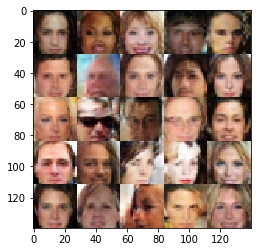

Epoch 4/10 Step 12500... Discriminator Loss: 1.3571... Generator Loss: 0.9262 ... Time spent=0.1321
Epoch 4/10 Step 12600... Discriminator Loss: 0.9909... Generator Loss: 0.9820 ... Time spent=0.1432


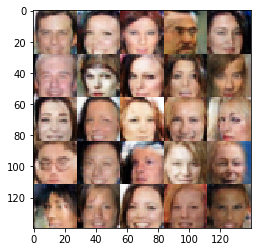

Epoch 5/10 Step 12700... Discriminator Loss: 1.2420... Generator Loss: 0.9040 ... Time spent=0.1324
Epoch 5/10 Step 12800... Discriminator Loss: 1.0078... Generator Loss: 0.8838 ... Time spent=0.1322


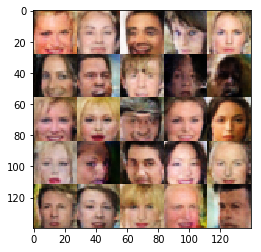

Epoch 5/10 Step 12900... Discriminator Loss: 0.8020... Generator Loss: 1.3630 ... Time spent=0.1409
Epoch 5/10 Step 13000... Discriminator Loss: 0.8717... Generator Loss: 1.1906 ... Time spent=0.1421


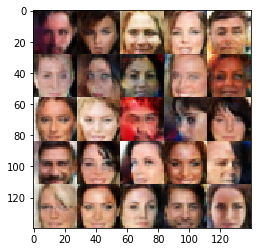

Epoch 5/10 Step 13100... Discriminator Loss: 0.7432... Generator Loss: 1.3375 ... Time spent=0.1417
Epoch 5/10 Step 13200... Discriminator Loss: 0.9999... Generator Loss: 0.9184 ... Time spent=0.1407


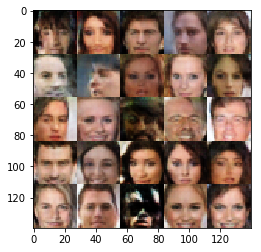

Epoch 5/10 Step 13300... Discriminator Loss: 0.9966... Generator Loss: 1.0745 ... Time spent=0.1373
Epoch 5/10 Step 13400... Discriminator Loss: 0.7222... Generator Loss: 1.4661 ... Time spent=0.1380


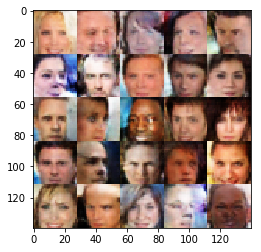

Epoch 5/10 Step 13500... Discriminator Loss: 0.6213... Generator Loss: 1.7827 ... Time spent=0.1368
Epoch 5/10 Step 13600... Discriminator Loss: 0.9030... Generator Loss: 1.1096 ... Time spent=0.1384


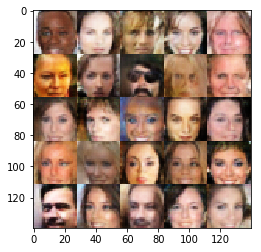

Epoch 5/10 Step 13700... Discriminator Loss: 0.8216... Generator Loss: 1.1654 ... Time spent=0.1367
Epoch 5/10 Step 13800... Discriminator Loss: 0.6118... Generator Loss: 2.0247 ... Time spent=0.1381


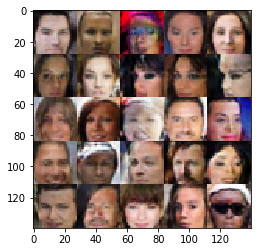

Epoch 5/10 Step 13900... Discriminator Loss: 1.1698... Generator Loss: 0.8049 ... Time spent=0.1318
Epoch 5/10 Step 14000... Discriminator Loss: 0.8904... Generator Loss: 1.1896 ... Time spent=0.1304


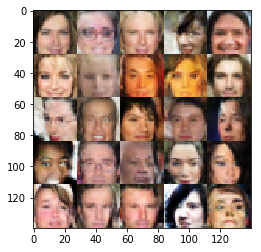

Epoch 5/10 Step 14100... Discriminator Loss: 0.6963... Generator Loss: 1.5761 ... Time spent=0.1306
Epoch 5/10 Step 14200... Discriminator Loss: 0.6975... Generator Loss: 1.4416 ... Time spent=0.1310


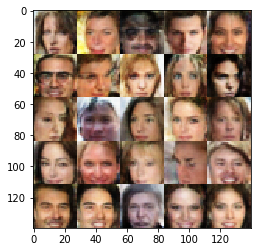

Epoch 5/10 Step 14300... Discriminator Loss: 0.6440... Generator Loss: 1.7564 ... Time spent=0.1393
Epoch 5/10 Step 14400... Discriminator Loss: 0.7788... Generator Loss: 1.3498 ... Time spent=0.1302


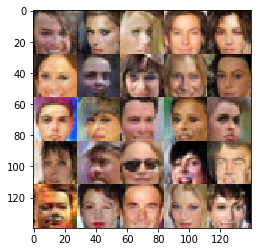

Epoch 5/10 Step 14500... Discriminator Loss: 0.9777... Generator Loss: 1.0278 ... Time spent=0.1305
Epoch 5/10 Step 14600... Discriminator Loss: 0.6828... Generator Loss: 1.8806 ... Time spent=0.1309


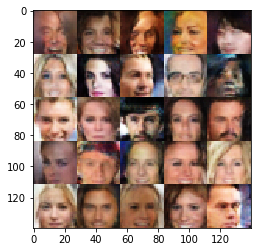

Epoch 5/10 Step 14700... Discriminator Loss: 1.0364... Generator Loss: 1.0072 ... Time spent=0.1391


In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

# TODO:

- Implement Dropout for both the GENERATOR and DISCRIMINATOR
- Implement more Convulutional Layers for both the GENERATOR and DISCRIMINATOR